# 네이버 쇼핑 데이터를 활용한 감성 분류

**참고문헌 : 위키독스 [딥러닝을 이용한 자연어 처리 입문]**

+ 11-6 ) 네이버 영화 리뷰 감성 분류하기 (Naver Movie Review Sentiment Analysis)
+ https://wikidocs.net/44249

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 로드하기

+ 1, 2, 3, 4점은 부정(0)으로, 5점은 긍정(1)로 라벨링 작업
+ import 된 Apple 네이버 쇼핑 데이터를 X, y로 나누기
+ train/test data 분리하기

In [3]:
data = pd.read_csv("네이버 쇼핑/Apple(shopping).csv", index_col = 0)
data.head()

,type,category,review,star
0,아이패드,별점,고장나서 옴 수리하기도 돈아까윰,1
1,아이패드,별점,그냥 모든게 허접해요,1
2,아이패드,별점,NaN,1
3,아이패드,별점,대응이 정말 안좋아요,1
4,아이패드,별점,액정 불량화소 있어서 말하니 센터가서 처리하라고하네 편하게 받고 싶은데 다시 가서 ...,1


In [4]:
##### 필요없는 category 컬럼 제거
df = data[["review", "star"]]
df

,review,star
0,고장나서 옴 수리하기도 돈아까윰,1
1,그냥 모든게 허접해요,1
2,NaN,1
3,대응이 정말 안좋아요,1
4,액정 불량화소 있어서 말하니 센터가서 처리하라고하네 편하게 받고 싶은데 다시 가서 ...,1
...,...,...
2414,왼쪽이 년 좀 넘게 쓰던 프로팟인데 자주 떨어트리고 물티슈로 자주닦아서 그런가 오른...,5
2415,년 월 제품이 왔습니다후기로 보아 제가 제일 오래된 상품인 듯하네요다른 분들은 다들...,5
2416,한달 넘게 사용중인 갤럭시 유저입니다 사용하는 내내 연결 끊김이나 문제 없었고 기능...,5
2417,너무너무 만족해요 기존에 에어팟무선 쓰고 있었는데 한쪽을 잃어버려서 고민하다가 프로...,5


In [5]:
##### star 데이터를 0과 1로 나누기
def star_change(value):
    if value <= 3 :
        return 0
    elif value >= 4:
        return 1

In [6]:
for i in range(len(df["star"])):
    df["star"][i] = star_change(df["star"][i])

<ipython-input-6-f3957571e3ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["star"][i] = star_change(df["star"][i])
C:\Users\shk97\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
df["star"].value_counts()

1    1821
0     598
Name: star, dtype: int64

In [8]:
df.info()
# null값 제거 필요

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2419 entries, 0 to 2418
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  2356 non-null   object
 1   star    2419 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 136.7+ KB


# 데이터 전처리

In [9]:
df.isnull().sum()
df = df.dropna().copy()
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2418
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  2356 non-null   object
 1   star    2356 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 55.2+ KB


In [10]:
##### 데이터 중복 제거
df.duplicated(["review"]).sum() # 76개의 중복 데이터
df = df.drop_duplicates().copy() # 2419개 --> 2350개
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2346 entries, 0 to 2418
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  2346 non-null   object
 1   star    2346 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 55.0+ KB


In [11]:
df.reset_index(drop = True)

,review,star
0,고장나서 옴 수리하기도 돈아까윰,0
1,그냥 모든게 허접해요,0
2,대응이 정말 안좋아요,0
3,액정 불량화소 있어서 말하니 센터가서 처리하라고하네 편하게 받고 싶은데 다시 가서 ...,0
4,일주일이 넘도록 환불처리가 되지 않아 빠른 답변 부탁드립니다,0
...,...,...
2341,왼쪽이 년 좀 넘게 쓰던 프로팟인데 자주 떨어트리고 물티슈로 자주닦아서 그런가 오른...,1
2342,년 월 제품이 왔습니다후기로 보아 제가 제일 오래된 상품인 듯하네요다른 분들은 다들...,1
2343,한달 넘게 사용중인 갤럭시 유저입니다 사용하는 내내 연결 끊김이나 문제 없었고 기능...,1
2344,너무너무 만족해요 기존에 에어팟무선 쓰고 있었는데 한쪽을 잃어버려서 고민하다가 프로...,1


In [12]:
len(df["star"])

2346

In [13]:
df.reset_index(drop = True)

,review,star
0,고장나서 옴 수리하기도 돈아까윰,0
1,그냥 모든게 허접해요,0
2,대응이 정말 안좋아요,0
3,액정 불량화소 있어서 말하니 센터가서 처리하라고하네 편하게 받고 싶은데 다시 가서 ...,0
4,일주일이 넘도록 환불처리가 되지 않아 빠른 답변 부탁드립니다,0
...,...,...
2341,왼쪽이 년 좀 넘게 쓰던 프로팟인데 자주 떨어트리고 물티슈로 자주닦아서 그런가 오른...,1
2342,년 월 제품이 왔습니다후기로 보아 제가 제일 오래된 상품인 듯하네요다른 분들은 다들...,1
2343,한달 넘게 사용중인 갤럭시 유저입니다 사용하는 내내 연결 끊김이나 문제 없었고 기능...,1
2344,너무너무 만족해요 기존에 에어팟무선 쓰고 있었는데 한쪽을 잃어버려서 고민하다가 프로...,1


# dataset 분리

In [14]:
# X = pd.DataFrame(df["review"])
# y = pd.DataFrame(df["star"])

In [15]:
##### train / test dataset 나누기
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size=0.3, shuffle=False, 
#                                                     random_state=1004)
# print("X_train:", X_train.shape, "X_test: ", X_test.shape)
# print("y_train: ", y_train.shape, "y_test: ", y_test.shape)

# 토큰화

In [16]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과',
             '도','를','으로','자','에','와','한','하다', '게',
             '고', '네', '는', '다', '들', '듯', '으로', '은',
             '을', '인', '임', '자', '좀', '지', '요']

In [17]:
okt = Okt()

In [18]:
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [19]:
train_data = df[:1643]
test_data = df[1643:]

X_train_token = []
for sentence in train_data["review"]:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train_token.append(temp_X)

In [20]:
print(X_train_token[:5])

[['고장', '나서다', '옴', '수리', '돈아까윰'], ['그냥', '모든', '허다', '접해'], ['대응', '정말', '안좋다'], ['액정', '불량화소', '있다', '말', '센터', '가다', '처리', '하', '라고', '편하다', '받다', '싶다', '다시', '가다', '처리', '시간', '돈', '누가', '보상', '해주다', '애플', '불량', '률', '높다', '건지다', '여기', '불량', '높다', '건지다'], ['일주일', '넘다', '환불', '처리', '되다', '않다', '빠르다', '답변', '부탁드리다']]


In [21]:
X_test_token = []
for sentence in test_data["review"]:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test_token.append(temp_X)

In [22]:
print(X_test_token[:5])

[['물건', '상태', '너무', '좋다', '가격', '착하다'], ['자다', '받다', '저렴하다', '가격', '구매', '감사하다'], ['감사하다', '자다', '받다'], ['자다', '수령', '자다', '수령'], ['만족스럽다', '모든', '구', '매', '처', '중', '제일', '저렴하다', '제작', '까지', '훌륭하다']]


# 정수 인코딩

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_token)

In [24]:
print(tokenizer.word_index)

{'좋다': 1, '있다': 2, '자다': 3, '너무': 4, '받다': 5, '로': 6, '보다': 7, '사용': 8, '구매': 9, '같다': 10, '없다': 11, '사다': 12, '쓰다': 13, '되다': 14, '애플': 15, '아이폰': 16, '이다': 17, '오다': 18, '것': 19, '하고': 20, '만족하다': 21, '제품': 22, '고민': 23, '아이패드': 24, '이쁘다': 25, '워치': 26, '예쁘다': 27, '에서': 28, '더': 29, '들다': 30, '않다': 31, '때': 32, '만': 33, '선물': 34, 'ㅎㅎ': 35, '주문': 36, '구입': 37, '안': 38, '가격': 39, '역시': 40, '생각': 41, '수': 42, '폰': 43, '많이': 44, '제': 45, '색상': 46, '일': 47, '그냥': 48, '정말': 49, '편하다': 50, '넘다': 51, '실버': 52, '좋아하다': 53, '저렴하다': 54, '중': 55, '미니': 56, '아주': 57, '가볍다': 58, '저': 59, '화면': 60, '프로': 61, '감사하다': 62, '기다리다': 63, '불량': 64, '포장': 65, '써다': 66, '운동': 67, '가다': 68, '없이': 69, '처음': 70, '잘쓰다': 71, '쓸다': 72, '빠르다': 73, '조금': 74, '할인': 75, 'ㅠㅠ': 76, '그렇다': 77, '못': 78, '크다': 79, '아니다': 80, '되어다': 81, '이라': 82, '다른': 83, '거': 84, '성능': 85, '마음': 86, '해주다': 87, '바로': 88, '진짜': 89, '정도': 90, '서': 91, '까지': 92, '아직': 93, '문제': 94, '맘': 95, '기능': 96, '디자인': 97, '라': 98, '상품': 99, '세대': 100, 

In [25]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold) :
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 3796
등장 빈도가 1번 이하인 희귀 단어의 수: 1758
단어 집합에서 희귀 단어의 비율: 46.31190727081138
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.909045074115156


In [26]:
# 전체 단어 개수 중 빈도수 1 이하인 단어는 제거
# 0번 패딩 토큰을 고려하여 + 1

vocab_size = total_cnt - rare_cnt + 1
print("단어 집합의 크기 : ", vocab_size)

단어 집합의 크기 :  2039


In [27]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train_token)
X_train_int = tokenizer.texts_to_sequences(X_train_token)
X_test_int = tokenizer.texts_to_sequences(X_test_token)

In [28]:
print(X_train_int[:5])

[[275, 383, 1190, 673], [48, 515, 553], [755, 49, 674], [147, 1470, 2, 101, 177, 68, 407, 114, 408, 50, 5, 108, 333, 68, 407, 109, 409, 1191, 87, 15, 64, 1471, 516, 384, 189, 64, 516, 384], [675, 51, 367, 407, 14, 31, 73, 995]]


In [29]:
y_train_int = np.array(train_data["star"])
y_test_int = np.array(test_data["star"])

# 빈 샘플(empty samples) 제거

In [30]:
drop_train = [index for index, sentence in enumerate(X_train_int) if len(sentence) < 1]

In [32]:
X_train_int = np.delete(X_train_int, drop_train, axis = 0)
y_train_int = np.delete(y_train_int, drop_train, axis = 0)
print(len(X_train_int))
print(len(y_train_int))

# 약 400개 가량 삭제됨

1639
1639


# 패딩

리뷰의 최대 길이 : 400
리뷰의 평균 길이 : 17.06772422208664


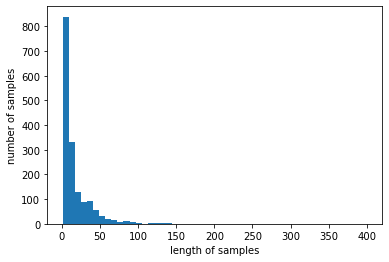

In [33]:
print("리뷰의 최대 길이 :", max(len(l) for l in X_train_int))
print("리뷰의 평균 길이 :", sum(map(len, X_train_int)) / len(X_train_int))
plt.hist([len(s) for s in X_train_int], bins = 50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

In [34]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [35]:
max_len = 80
below_threshold_len(max_len, X_train_int)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 97.62050030506406


In [36]:
X_train_int = pad_sequences(X_train_int, maxlen = max_len)
X_test_int = pad_sequences(X_test_int, maxlen = max_len)

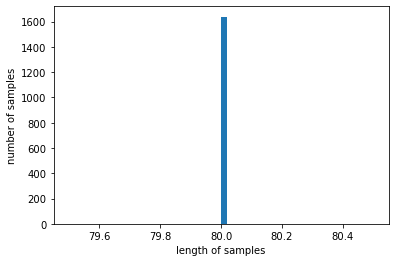

In [37]:
plt.hist([len(s) for s in X_train_int], bins = 50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

In [38]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [39]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation="sigmoid"))

In [40]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor="val_acc", mode='max', verbose=1,
                     save_best_only=True)

In [41]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=["acc"])
history = model.fit(X_train_int, y_train_int, epochs = 15, callbacks=[es, mc],
                    batch_size=60, validation_split=0.2)

Epoch 1/15
22/22 [==============================] - 4s 133ms/step - loss: 0.4533 - acc: 0.8421 - val_loss: 0.2596 - val_acc: 0.9329

Epoch 00001: val_acc improved from -inf to 0.93293, saving model to best_model.h5
Epoch 2/15
22/22 [==============================] - 2s 100ms/step - loss: 0.3853 - acc: 0.8619 - val_loss: 0.2314 - val_acc: 0.9329

Epoch 00002: val_acc did not improve from 0.93293
Epoch 3/15
22/22 [==============================] - 2s 97ms/step - loss: 0.3166 - acc: 0.8711 - val_loss: 0.2147 - val_acc: 0.9360

Epoch 00003: val_acc improved from 0.93293 to 0.93598, saving model to best_model.h5
Epoch 4/15
22/22 [==============================] - 2s 101ms/step - loss: 0.2395 - acc: 0.9069 - val_loss: 0.2210 - val_acc: 0.9390

Epoch 00004: val_acc improved from 0.93598 to 0.93902, saving model to best_model.h5
Epoch 5/15
22/22 [==============================] - 2s 101ms/step - loss: 0.1955 - acc: 0.9230 - val_loss: 0.2489 - val_acc: 0.9268

Epoch 00005: val_acc did not impro

In [42]:
loaded_model = load_model('best_model.h5')
print('\n 테스트 정확도: %.4f' % (loaded_model.evaluate(X_test_int, y_test_int)[1]))

22/22 [==============================] - 1s 26ms/step - loss: 1.3285 - acc: 0.5078

 테스트 정확도: 0.5078


In [43]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [44]:
sentiment_predict('역시 애플 좋네요')

93.04% 확률로 긍정 리뷰입니다.



In [49]:
sentiment_predict("배송 최악 양심없냐?")

69.36% 확률로 긍정 리뷰입니다.



In [46]:
sentiment_predict("이걸 쓰라고 만든거냐 엉망이다")

77.02% 확률로 긍정 리뷰입니다.



In [47]:
sentiment_predict("아주그냥 쓰레기통에 넣어버리던가 최악 배송최악 아주싫어")

85.73% 확률로 긍정 리뷰입니다.



In [50]:
sentiment_predict("어떻게 써야 부정리뷰 해줄래..")

58.64% 확률로 긍정 리뷰입니다.



In [51]:
sentiment_predict("제발 부정이라고 해줘 애플 너무 싫어 안쓸거야 절대로")

69.23% 확률로 긍정 리뷰입니다.

